https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V3: concatenate images as input

# Attention Map

In [1]:
# CONFIG
# model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model_name = "facebook/sam2.1-hiera-small"
data_dir = "/home/minsukc/SIO/data/"
target_image_1 = "ct_chest_2.png"
# target_image_2 = "ct_chest_2_translated_100_100.png"
target_image_2 = "ct_chest_1.jpeg"
# target_image_2 = "ct_chest_2_translated_300_300.png"

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Sam2Processor, Sam2Model

# from transformers import AutoProcessor, Sam2VisionModel
from transformers.image_utils import load_image
import os

/home/minsukc/micromamba/envs/sio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load model & image
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using device: {device}")

processor = Sam2Processor.from_pretrained(model_name)
sam2 = Sam2Model.from_pretrained(model_name)
model = sam2.vision_encoder
model = model.to(device)

image1 = load_image(os.path.join(data_dir, target_image_1))
image2 = load_image(os.path.join(data_dir, target_image_2))

# Match image sizes before concatenation
w1, h1 = image1.size
w2, h2 = image2.size
target_h = min(h1, h2)
target_w = min(w1, w2)

image1 = image1.resize((target_w, target_h))
image2 = image2.resize((target_w, target_h))

# 🔹 Choose concatenation direction:
concat_direction = "horizontal"  # or "vertical"

if concat_direction == "horizontal":
    concat_image = Image.new("RGB", (target_w * 2, target_h))
    concat_image.paste(image1, (0, 0))
    concat_image.paste(image2, (target_w, 0))
elif concat_direction == "vertical":
    concat_image = Image.new("RGB", (target_w, target_h * 2))
    concat_image.paste(image1, (0, 0))
    concat_image.paste(image2, (0, target_h))
else:
    raise ValueError("concat_direction must be 'horizontal' or 'vertical'")

image = concat_image

Using device: cuda


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


In [ ]:
inputs = processor(
    images=image,
    do_resize=False,  # 🔹 disable forced 224 resize
    do_center_crop=False,  # 🔹 skip center crop
    return_tensors="pt",
).to(device)
inputs.pixel_values.shape

torch.Size([1, 3, 1024, 2048])

In [52]:
with torch.no_grad():
    # outputs = model(**inputs)
    outputs = model(**inputs, output_hidden_states=True)
    # feats = outputs.image_embeddings[0]   # [C, H', W']
    # feats = outputs.last_hidden_state[0]   # shape [C, H', W']
for i, h in enumerate(outputs.hidden_states):
    print(f"Layer {i}: {tuple(h.shape)}")

Layer 0: (1, 256, 512, 96)
Layer 1: (1, 256, 512, 96)
Layer 2: (1, 128, 256, 192)
Layer 3: (1, 128, 256, 192)
Layer 4: (1, 64, 128, 384)
Layer 5: (1, 64, 128, 384)
Layer 6: (1, 64, 128, 384)
Layer 7: (1, 64, 128, 384)
Layer 8: (1, 64, 128, 384)
Layer 9: (1, 64, 128, 384)
Layer 10: (1, 64, 128, 384)
Layer 11: (1, 64, 128, 384)
Layer 12: (1, 64, 128, 384)
Layer 13: (1, 64, 128, 384)
Layer 14: (1, 64, 128, 384)
Layer 15: (1, 32, 64, 768)
Layer 16: (1, 32, 64, 768)


In [ ]:
# feats = outputs.hidden_states[10][0]  # [48, 48, 384]
feats = outputs.hidden_states[-3][0]  # [48, 48, 384]
# feats = outputs.hidden_states[-1][0]  # [48, 48, 384]
# feats = outputs.hidden_states[-1][0]  # [48, 48, 384]
Hf, Wf, C = feats.shape
patch_feats = feats.reshape(Hf * Wf, C)  # [N_patches, C]
print(f"Feature map: {Hf}x{Wf}, dim={C}")

Feature map: 64x128, dim=384


# Patch Similarity Map

In [54]:
patch_h, patch_w = Hf, Wf
num_patches = patch_feats.shape[0]
print(f"Feature grid: {patch_h}x{patch_w}, total patches: {num_patches}")

Feature grid: 64x128, total patches: 8192


In [55]:
# --- Create a grid of query patch indices (works for non-square grids) ---
grid_size = 4  # 4x4 = 16 query points
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

n_queries = len(query_indices)
cols, rows = grid_size, grid_size
print(f"Query grid: {rows}x{cols}, total {n_queries} queries")

Query grid: 4x4, total 16 queries


Patch grid: 64x128, queries: 16
Similarity map shape: (64, 128)


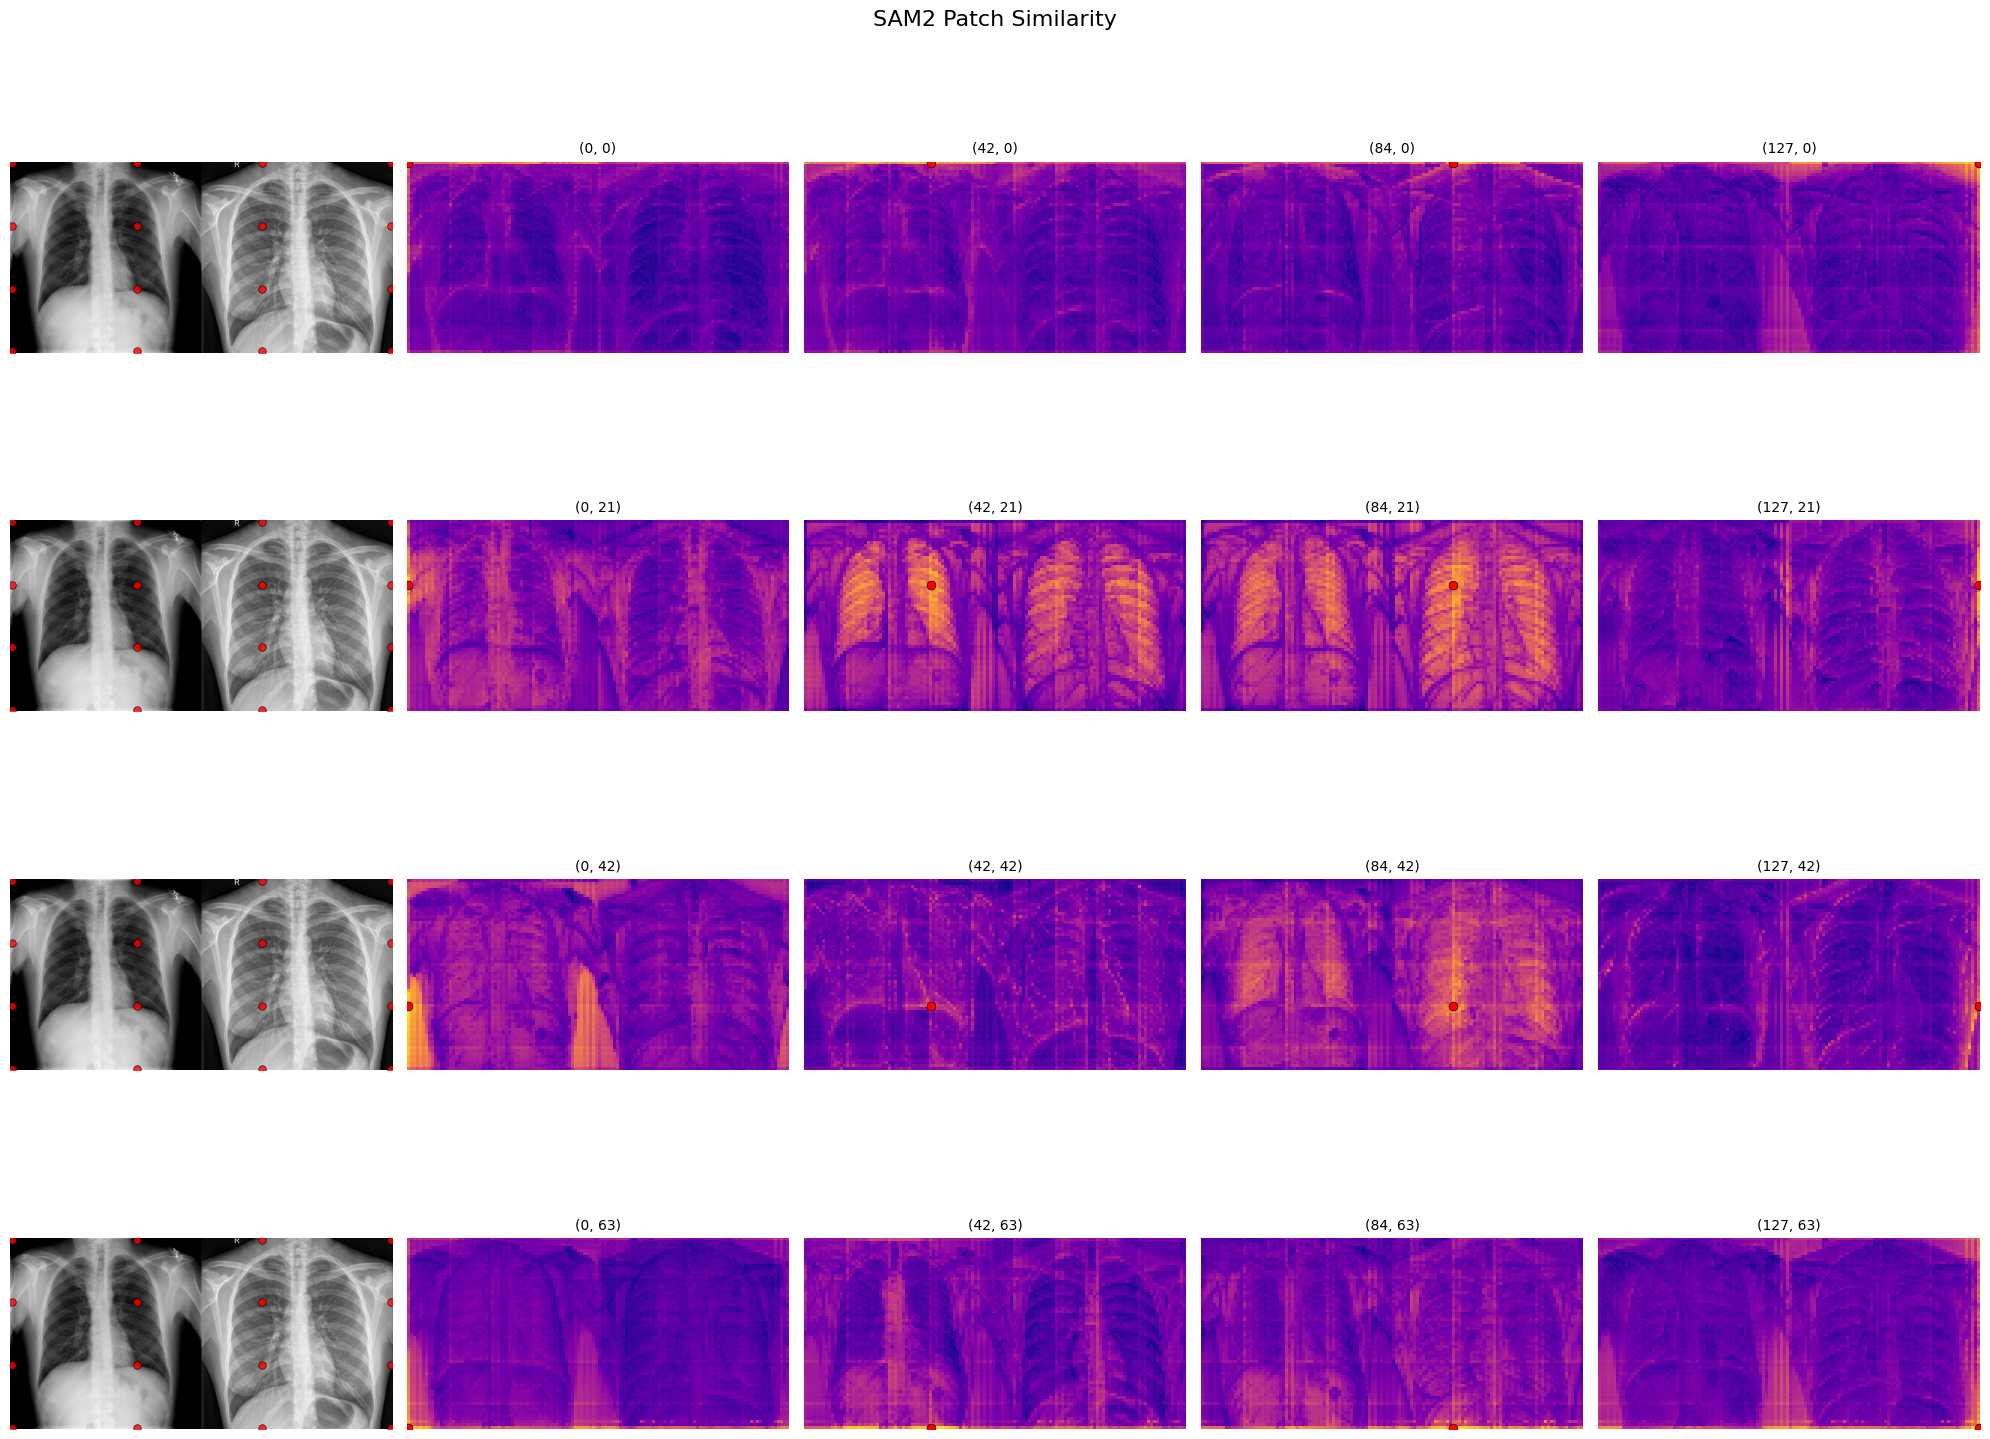

In [ ]:
# --- Patch grid from feature map (robust for non-square inputs) ---
patch_h, patch_w = Hf, Wf  # from feats.shape earlier
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, (
    f"Expected {patch_h * patch_w}, got {num_patches}"
)

# --- Create evenly spaced query patches ---
grid_size = 4
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

cols = grid_size
rows = grid_size
print(f"Patch grid: {patch_h}x{patch_w}, queries: {len(query_indices)}")

# ---- Figure setup ----
fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# ---- Left column: original image ----
for r in range(rows):
    ax_img = axes[r, 0]
    ax_img.imshow(image)
    ax_img.axis("off")

    # mark query patch centers
    for q_idx in query_indices:
        qy, qx = divmod(q_idx, patch_w)
        img_w, img_h = image.size
        center_x = (qx + 0.5) * (img_w / patch_w)
        center_y = (qy + 0.5) * (img_h / patch_h)
        ax_img.scatter(
            center_x,
            center_y,
            color="red",
            s=30,
            marker="o",
            edgecolors="black",
            linewidth=0.5,
            alpha=0.8,
        )

# ---- Right grid: similarity maps ----
ax_list = [
    axes[r, c] if rows > 1 else axes[c] for r in range(rows) for c in range(1, cols + 1)
]

for ax, q_idx in zip(ax_list, query_indices):
    query_feat = patch_feats[q_idx : q_idx + 1]
    sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
    sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)

    qy, qx = divmod(q_idx, patch_w)
    ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
    ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
    ax.set_title(f"({qx}, {qy})", fontsize=10)
    ax.axis("off")

print(f"Similarity map shape: {sim_map.shape}")
plt.suptitle("SAM2 Patch Similarity", fontsize=16)
plt.tight_layout()
plt.show()


# PCA

In [ ]:
from sklearn.decomposition import PCA

# patch_feats: [N_patches, hidden_dim], e.g., [3072, 384]
feats = patch_feats.cpu().numpy()

# Apply PCA → project hidden_dim → 3 components
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)  # shape: [N_patches, 3]

# Normalize each PCA channel to [0, 1]
pca_min = pca_feats.min(axis=0, keepdims=True)
pca_max = pca_feats.max(axis=0, keepdims=True)
pca_norm = (pca_feats - pca_min) / (pca_max - pca_min + 1e-8)

# --- Use true patch grid from feature map ---
patch_h, patch_w = Hf, Wf  # from feats.shape earlier

# Sanity check
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, (
    f"Expected {patch_h * patch_w}, got {num_patches}"
)

# --- Reshape PCA features into spatial layout ---
pca_image = pca_norm.reshape(patch_h, patch_w, 3)


(64, 128, 3)


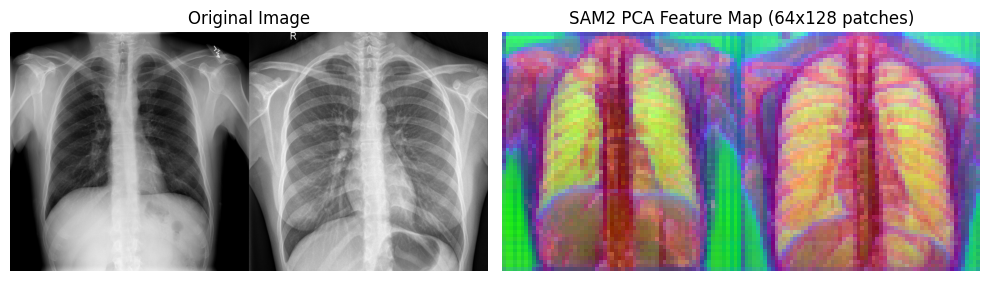

In [ ]:
print(pca_image.shape)
# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(pca_image, interpolation="nearest")
# axes[1].imshow(pca_image,interpolation="bilinear")
axes[1].set_title(f"SAM2 PCA Feature Map ({patch_h}x{patch_w} patches)")
axes[1].axis("off")

plt.tight_layout()
plt.show()